Shapes => train: (646, 33) | test: (277, 32)
Detected id_col = id | target_col = labels
Limpeza avançada (modo com NAs) ...
Indicadores de missing criados: 3
Rare grouping aplicado em: 1
Removidas por alta correlação: 1
Removed summary:
 - high_missing: 0
 - quasi_constant: 1
 - id_like: 0
 - advanced.high_corr: 1
Remaining features: 34
Train rows after cleaning: 646
Class distribution: {np.int64(0): np.int64(228), np.int64(1): np.int64(418)}
High-card cols: ['category_code']
Target encoded cols: ['category_code_te']
MI filter desativado (USE_MI_FILTER=False).
Numeric feats: 34 | Categorical feats: 0
OneHot? False
Class weights: {np.int64(0): np.float64(1.4166666666666667), np.int64(1): np.float64(0.7727272727272727)}
Fold 1: acc=0.8280 | bal_acc=0.7780 | kept_feats=28
Fold 2: acc=0.7957 | bal_acc=0.7530 | kept_feats=28
Fold 3: acc=0.7500 | bal_acc=0.7250 | kept_feats=28
Fold 4: acc=0.7826 | bal_acc=0.7437 | kept_feats=28
Fold 5: acc=0.7174 | bal_acc=0.6375 | kept_feats=28
Fold 6: acc=

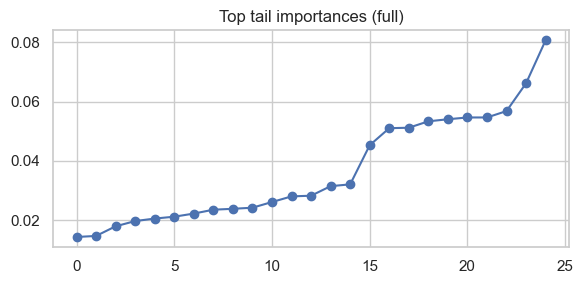

In [48]:
# Notebook unificado (versão avançada) – Objetivo agora: maximizar ACCURACY (não balanced) de forma estável
# Ajustes feitos nesta versão:
# - Foco em accuracy => ENSEMBLE_SCORE_PRIORITY='accuracy'
# - Desativado REMOVE_ALL_NA para não perder linhas/colunas com possível sinal
# - Desativado USE_MI_FILTER para evitar dupla poda de features
# - Aumentado FS_KEEP_PCT para manter mais variáveis (0.85)
# - Desativadas interações automáticas (ENABLE_INTERACTIONS=False) para reduzir ruído inicial
# - Smoothing do target encoding reduzido (TE_SMOOTH=8) para preservar contraste
# - Mantido threshold tuning (pode escolher melhor acc se desejado)
# - Pode reativar gradualmente componentes para testar ganhos incrementais.

# Se quiser voltar a priorizar balanced accuracy basta trocar ENSEMBLE_SCORE_PRIORITY e (opcional) reativar class weighting custom e threshold focado em balanced.

# AVISO: Execute esta célula inteira após as mudanças.

# (Linhas originais mantidas mais abaixo com modificações nas flags iniciais)

import warnings, os, gc, math
warnings.filterwarnings('ignore')
import numpy as np, pandas as pd
from time import time

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, accuracy_score, balanced_accuracy_score,
                             f1_score)
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(7,4)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
# ===== FLAGS AJUSTADAS PARA ACCURACY =====
FAST_MODE = False        # False => mais árvores e mais folds (melhor estabilidade)
RUN_TUNING = False       # Pode colocar True depois que baseline accuracy estabilizar
N_SPLITS_MAIN = 7 if not FAST_MODE else 5
FS_KEEP_PCT = 0.85       # manter 85% por importância (antes 0.60)
TOP_K_CORR = 6           # irrelevante agora (interações desativadas)
ENABLE_INTERACTIONS = False   # desligado para baseline limpo
ADJUST_DECISION_THRESHOLD = True  # manter para tentar ligeiro ganho em accuracy
ADVANCED_CLEANING = True          # continua ligado (sem remoção total de NA)

# Flags de melhoria
USE_MI_FILTER = False             # desligado para não podar demais cedo
MI_KEEP_PCT = 0.80                # se reativar, pode subir para 0.9+
USE_WEIGHT_OPT = True             # ainda útil para accuracy
WEIGHT_OPT_SAMPLES = 400          # pode reduzir para 200 se lento
ENSEMBLE_SCORE_PRIORITY = 'accuracy'  # prioridade agora é accuracy
REPEAT_CV = 1                     # pode aumentar depois para estabilizar métricas
THRESH_GRID = np.linspace(0.3,0.7,41)  # usado no tuning de threshold
REMOVE_ALL_NA = False             # NÃO remover tudo que tem NA; usar imputação depois
TE_SMOOTH = 8                     # novo smoothing para target encoding (antes usava 15)

# 1) Carregar
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
sample_sub = pd.read_csv('sample_submission.csv')
print('Shapes => train:', train.shape, '| test:', test.shape)

# 2) Detectar id/target

def detect_id_and_target(train_df, test_df):
    id_col = None
    for c in train_df.columns:
        cl = c.lower()
        if cl=='id' or cl.endswith('_id'):
            id_col = c; break
    if id_col is None:
        commons = list(set(train_df.columns)&set(test_df.columns))
        for c in commons:
            if train_df[c].nunique() >= 0.8*len(train_df):
                id_col=c; break
        if id_col is None and commons:
            id_col=commons[0]
    train_cols=set(train_df.columns); test_cols=set(test_df.columns)
    candidates=[c for c in (train_cols-test_cols) if c!=id_col]
    target_col=None
    if len(candidates)==1: target_col=candidates[0]
    else:
        for name in ['target','label','y','response','status','final_status','survived','is_success','success','labels']:
            if name in train_df.columns: target_col=name; break
    if target_col is None:
        for c in train_df.columns:
            if c==id_col: continue
            un=train_df[c].nunique()
            if 2<=un<=12: target_col=c; break
    return id_col, target_col

id_col, target_col = detect_id_and_target(train, test)
print('Detected id_col =', id_col, '| target_col =', target_col)
assert target_col is not None, 'Defina manualmente a coluna target.'

# 3) Limpeza
clean_train = train.copy(); clean_test = test.copy()
removed={}
MISS_THR=0.60
miss_frac = clean_train.isna().mean()
high_miss = [c for c,v in miss_frac.items() if v>MISS_THR and c not in [target_col, id_col]]
removed['high_missing']=high_miss
clean_train.drop(columns=high_miss, inplace=True, errors='ignore')
clean_test.drop(columns=[c for c in high_miss if c in clean_test.columns], inplace=True, errors='ignore')

# NÃO remover tudo que tem NA (REMOVE_ALL_NA=False) => Mantemos linhas e usamos imputação depois
# Ainda podemos criar indicadores de missing mais tarde se quiser.
if REMOVE_ALL_NA:
    raise RuntimeError('REMOVE_ALL_NA deveria estar False no modo accuracy baseline.')

# quasi-constant >98%
qconst=[]
for c in clean_train.columns:
    if c in [target_col, id_col]: continue
    vc=clean_train[c].value_counts(dropna=False, normalize=True)
    if len(vc)>0 and vc.iloc[0]>0.98: qconst.append(c)
removed['quasi_constant']=qconst
clean_train.drop(columns=qconst, inplace=True, errors='ignore')
clean_test.drop(columns=[c for c in qconst if c in clean_test.columns], inplace=True, errors='ignore')

# id-like >=95%
id_like=[]
for c in clean_train.columns:
    if c in [target_col, id_col]: continue
    if clean_train[c].nunique(dropna=False)>=0.95*len(clean_train): id_like.append(c)
removed['id_like']=id_like
clean_train.drop(columns=id_like, inplace=True, errors='ignore')
clean_test.drop(columns=[c for c in id_like if c in clean_test.columns], inplace=True, errors='ignore')

# missing row features (mantemos NAs => indicadores são úteis)
clean_train['row_missing_count']=clean_train.isna().sum(axis=1)
clean_train['row_missing_ratio']=clean_train['row_missing_count']/(clean_train.shape[1]-1)
clean_test['row_missing_count']=clean_test.isna().sum(axis=1)
clean_test['row_missing_ratio']=clean_test['row_missing_count']/clean_test.shape[1]

# outlier clipping (pode desativar se perder sinal)
NUM_CLIP_Q=(0.01,0.99)
for c in clean_train.select_dtypes(include=[np.number]).columns:
    if c==target_col: continue
    q1,q2=clean_train[c].quantile(NUM_CLIP_Q)
    if q1==q2: continue
    clean_train[c]=clean_train[c].clip(q1,q2)
    if c in clean_test.columns:
        clean_test[c]=clean_test[c].clip(q1,q2)

# Limpeza avançada (continua válida; agora há NAs)
if ADVANCED_CLEANING:
    print('Limpeza avançada (modo com NAs) ...')
    adv_removed = {}
    def downcast_df(df):
        for col in df.select_dtypes(include=['int64','int32']).columns:
            df[col] = pd.to_numeric(df[col], downcast='integer')
        for col in df.select_dtypes(include=['float64','float32']).columns:
            df[col] = pd.to_numeric(df[col], downcast='float')
    downcast_df(clean_train); downcast_df(clean_test)
    # Missing indicators (moderados)
    miss_frac2 = clean_train.isna().mean()
    miss_indicator_cols = [c for c,v in miss_frac2.items() if 0.02 <= v <= MISS_THR and c not in [target_col, id_col]]
    for c in miss_indicator_cols:
        clean_train[f'miss__{c}'] = clean_train[c].isna().astype(int)
        if c in clean_test.columns:
            clean_test[f'miss__{c}'] = clean_test[c].isna().astype(int)
    print(f'Indicadores de missing criados: {len(miss_indicator_cols)}')
    # Rare grouping leve
    cat_cols = [c for c in clean_train.select_dtypes(exclude=[np.number]).columns if c not in [target_col, id_col]]
    RARE_CAT_THR = 0.003
    rare_mappings = {}
    for c in cat_cols:
        vc = clean_train[c].value_counts(normalize=True)
        if 5 <= len(vc) <= 60:
            rares = vc[vc < RARE_CAT_THR].index
            if len(rares)>0:
                clean_train[c] = clean_train[c].where(~clean_train[c].isin(rares), '__rare__')
                if c in clean_test.columns:
                    clean_test[c] = clean_test[c].where(~clean_test[c].isin(rares), '__rare__')
                rare_mappings[c]=list(rares)
    print('Rare grouping aplicado em:', len(rare_mappings))
    # Correlação muito alta (quase duplicatas)
    CORR_DROP_THR = 0.997
    num_cols_corr = [c for c in clean_train.select_dtypes(include=[np.number]).columns if c not in [target_col]]
    if len(num_cols_corr) > 1:
        corr = clean_train[num_cols_corr].corr().abs()
        upper = corr.where(np.triu(np.ones(corr.shape), 1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > CORR_DROP_THR)]
        if to_drop:
            clean_train.drop(columns=to_drop, inplace=True, errors='ignore')
            clean_test.drop(columns=[c for c in to_drop if c in clean_test.columns], inplace=True, errors='ignore')
            adv_removed['high_corr'] = to_drop
            print(f'Removidas por alta correlação: {len(to_drop)}')
    removed['advanced']=adv_removed
else:
    print('ADVANCED_CLEANING=False (nenhuma limpeza extra).')

features=[c for c in clean_train.columns if c not in [target_col, id_col]]
print('Removed summary:')
def _print_removed_summary(rem_map):
    def summarize_entry(prefix, val):
        if isinstance(val, dict):
            for kk, vv in val.items():
                summarize_entry(f'{prefix}.{kk}', vv)
        else:
            if isinstance(val, (list, tuple, set)):
                print(f' - {prefix}: {len(val)}')
            else:
                try:
                    l = len(val)
                    print(f' - {prefix}: {l}')
                except TypeError:
                    print(f' - {prefix}: {val}')
    for k,v in rem_map.items():
        summarize_entry(k, v)
_print_removed_summary(removed)
print('Remaining features:', len(features))
print('Train rows after cleaning:', len(clean_train))

# 4) X/y
X = clean_train[features].copy(); y = clean_train[target_col].copy()
le_target = LabelEncoder(); y_enc = le_target.fit_transform(y)
classes_, counts = np.unique(y_enc, return_counts=True)
print('Class distribution:', dict(zip(classes_, counts)))

# 5) Target encoding alta cardinalidade
HIGH_CARD_THR=30
initial_cat = X.select_dtypes(exclude=[np.number]).columns.tolist()
high_card = [c for c in initial_cat if X[c].nunique()>HIGH_CARD_THR]
print('High-card cols:', high_card)

def target_encode_oof(train_series, y_encoded, test_series, n_splits=5, smoothing=TE_SMOOTH):
    global_mean = y_encoded.mean()
    oof = np.zeros(len(train_series), dtype=float)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
    ser_tr = train_series.astype(str); ser_te = test_series.astype(str)
    for tr_idx, va_idx in skf.split(ser_tr, y_encoded):
        part = ser_tr.iloc[tr_idx]; yy = y_encoded[tr_idx]
        df = part.to_frame('val'); df['y']=yy
        agg=df.groupby('val')['y'].agg(['mean','count'])
        agg['te']=(agg['mean']*agg['count'] + global_mean*smoothing)/(agg['count']+smoothing)
        mp=agg['te'].to_dict()
        oof[va_idx]=ser_tr.iloc[va_idx].map(mp).fillna(global_mean)
    full=ser_tr.to_frame('val'); full['y']=y_encoded
    agg_full=full.groupby('val')['y'].agg(['mean','count'])
    agg_full['te']=(agg_full['mean']*agg_full['count']+global_mean*smoothing)/(agg_full['count']+smoothing)
    mp_full=agg_full['te'].to_dict()
    test_vals = ser_te.map(mp_full).fillna(global_mean).values
    return oof, test_vals

X_te = X.copy(); test_te = clean_test[features].copy(); te_created=[]
for c in high_card:
    tr_vals, te_vals = target_encode_oof(X[c], y_enc, test_te[c], n_splits=5, smoothing=TE_SMOOTH)
    new_col = c+'_te'
    X_te[new_col]=tr_vals; test_te[new_col]=te_vals
    X_te.drop(columns=[c], inplace=True); test_te.drop(columns=[c], inplace=True)
    te_created.append(new_col)
print('Target encoded cols:', te_created)

# 5.1) Mutual Information filter (DESLIGADO)
if USE_MI_FILTER:
    from sklearn.feature_selection import mutual_info_classif
    tmp = X_te.copy()
    for col in tmp.columns:
        if tmp[col].dtype.kind in 'biufc':
            tmp[col] = tmp[col].fillna(tmp[col].median())
        else:
            tmp[col] = tmp[col].astype('category').cat.codes
    mi = mutual_info_classif(tmp, y_enc, discrete_features=False, random_state=RANDOM_STATE)
    mi_series = pd.Series(mi, index=tmp.columns).sort_values(ascending=False)
    k_keep_mi = max(5, int(len(mi_series)*MI_KEEP_PCT))
    keep_cols_mi = mi_series.index[:k_keep_mi].tolist()
    drop_mi = [c for c in X_te.columns if c not in keep_cols_mi]
    if drop_mi:
        X_te.drop(columns=drop_mi, inplace=True, errors='ignore')
        test_te = test_te[[c for c in test_te.columns if c in X_te.columns]]
    print(f'MI filter aplicado: mantidas {k_keep_mi}/{len(mi_series)} features.')
else:
    print('MI filter desativado (USE_MI_FILTER=False).')

# 6) Interações – desativadas para baseline accuracy
if ENABLE_INTERACTIONS:
    raise RuntimeError('ENABLE_INTERACTIONS deveria estar False no baseline. Ajuste a flag se quiser ativar.')

# 7) Recalcular tipos finais
numeric_feats = X_te.select_dtypes(include=[np.number]).columns.tolist()
categorical_feats = X_te.select_dtypes(exclude=[np.number]).columns.tolist()
print('Numeric feats:', len(numeric_feats), '| Categorical feats:', len(categorical_feats))

ONEHOT_CAP = 400
use_onehot = len(categorical_feats)>0 and sum(X_te[c].nunique() for c in categorical_feats) <= ONEHOT_CAP

num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

if use_onehot:
    try:
        cat_pipe = Pipeline([
            ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
            ('oh', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
    except TypeError:
        cat_pipe = Pipeline([
            ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
            ('oh', OneHotEncoder(handle_unknown='ignore', sparse=False))
])
else:
    cat_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='constant', fill_value='missing')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
]) if categorical_feats else 'drop'

transformers=[]
if numeric_feats: transformers.append(('num', num_pipe, numeric_feats))
if categorical_feats: transformers.append(('cat', cat_pipe, categorical_feats))
preprocessor = ColumnTransformer(transformers=transformers, sparse_threshold=0)
print('OneHot?', use_onehot)

# 8) Class weights (mantém balanced para não destruir recall da minoria, mesmo priorizando accuracy)
class_weights = compute_class_weight(class_weight='balanced', classes=classes_, y=y_enc)
class_weight_dict = {cls:w for cls,w in zip(classes_, class_weights)}
print('Class weights:', class_weight_dict)

# 9) Model definitions (mais árvores porque FAST_MODE=False)
rf_base = RandomForestClassifier(n_estimators=800 if not FAST_MODE else 400,
                                max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
ext_base = ExtraTreesClassifier(n_estimators=1000 if not FAST_MODE else 500,
                                max_depth=None, min_samples_split=2, min_samples_leaf=1,
                                class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
hgb_base = HistGradientBoostingClassifier(learning_rate=0.06, max_leaf_nodes=63,
                                          min_samples_leaf=15, random_state=RANDOM_STATE)
base_models = [('rf', rf_base), ('et', ext_base), ('hgb', hgb_base)]

if RUN_TUNING:
    print('Iniciando tuning...')
    tuned_models = []
    cv_tune = 5 if not FAST_MODE else 3
    rf_params = {
        'clf__n_estimators': [600,800,1000],
        'clf__max_depth': [None, 8, 12, 16],
        'clf__min_samples_split': [2,4,6],
        'clf__min_samples_leaf': [1,2,3]
    }
    et_params = {
        'clf__n_estimators': [800,1000,1200],
        'clf__max_depth': [None, 8, 12, 16],
        'clf__min_samples_split': [2,4,6],
        'clf__min_samples_leaf': [1,2,3]
    }
    hgb_params = {
        'clf__learning_rate': [0.04,0.06,0.08],
        'clf__max_leaf_nodes': [31,63,127],
        'clf__min_samples_leaf': [5,10,15,25]
    }
    search_spaces = [
        ('rf', rf_base, rf_params),
        ('et', ext_base, et_params),
        ('hgb', hgb_base, hgb_params)
    ]
    for name, base, params in search_spaces:
        pipe = Pipeline([('prep', preprocessor), ('clf', clone(base))])
        rs = RandomizedSearchCV(pipe, params, n_iter=12, cv=cv_tune,
                                scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
        rs.fit(X_te, y_enc)
        print(f'{name} best acc: {rs.best_score_:.4f} params: {rs.best_params_}')
        tuned_models.append((name, rs.best_estimator_.named_steps['clf']))
    base_models = tuned_models
    print('Tuning concluído.')

# 11) CV + seleção por fold + ensemble
cv = StratifiedKFold(n_splits=N_SPLITS_MAIN, shuffle=True, random_state=RANDOM_STATE)
num_classes = len(classes_)
base_oof_list = {name: np.zeros((len(X_te), num_classes)) for name,_ in base_models}
oof_probs = np.zeros((len(X_te), num_classes))
feature_importances_accum=[]
fold_accs=[]; fold_bal_acc=[]
start = time()

for rep in range(REPEAT_CV):
    if REPEAT_CV>1: print(f'== Repetition {rep+1}/{REPEAT_CV} ==')
    cv = StratifiedKFold(n_splits=N_SPLITS_MAIN, shuffle=True, random_state=RANDOM_STATE+rep)
    for fold,(tr,va) in enumerate(cv.split(X_te, y_enc),1):
        X_tr, X_va = X_te.iloc[tr], X_te.iloc[va]
        y_tr, y_va = y_enc[tr], y_enc[va]
        prep = clone(preprocessor)
        Z_tr_full = prep.fit_transform(X_tr, y_tr)
        Z_va_full = prep.transform(X_va)
        fs_model = ExtraTreesClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1,
                                        class_weight='balanced')
        fs_model.fit(Z_tr_full, y_tr)
        importances = fs_model.feature_importances_
        feature_importances_accum.append(importances)
        k_keep = max(10, int(len(importances)*FS_KEEP_PCT))
        idx_sorted = np.argsort(importances)[::-1][:k_keep]
        Z_tr = Z_tr_full[:, idx_sorted]; Z_va = Z_va_full[:, idx_sorted]
        fold_probs_list=[]
        sample_w = np.array([class_weight_dict[c] for c in y_tr])
        for name, mdl in base_models:
            m = clone(mdl)
            if isinstance(m, HistGradientBoostingClassifier):
                m.fit(Z_tr, y_tr, sample_weight=sample_w)
            else:
                m.fit(Z_tr, y_tr)
            probs = m.predict_proba(Z_va)
            base_oof_list[name][va] = probs
            fold_probs_list.append(probs)
        avg_probs = np.mean(fold_probs_list, axis=0)
        preds = avg_probs.argmax(axis=1)
        acc = accuracy_score(y_va, preds)
        bal_acc = balanced_accuracy_score(y_va, preds)
        fold_accs.append(acc); fold_bal_acc.append(bal_acc)
        oof_probs[va]=avg_probs
        print(f'Fold {fold}: acc={acc:.4f} | bal_acc={bal_acc:.4f} | kept_feats={k_keep}')

cv_mean = np.mean(fold_accs); cv_bal_mean = np.mean(fold_bal_acc)
print(f'CV mean acc={cv_mean:.4f} | CV balanced acc={cv_bal_mean:.4f}')

# 11.1) Otimização de pesos (agora usando accuracy)
opt_weights = None
if USE_WEIGHT_OPT and len(base_models)>1:
    model_names = [name for name,_ in base_models]
    mats = [base_oof_list[name] for name in model_names]
    mats = np.stack(mats, axis=0)
    best_score = -1
    rng = np.random.default_rng(RANDOM_STATE)
    for i in range(WEIGHT_OPT_SAMPLES):
        w = rng.dirichlet(np.ones(len(model_names)))
        blended = np.tensordot(w, mats, axes=1)
        pred = blended.argmax(axis=1)
        score = accuracy_score(y_enc, pred)
        if score>best_score:
            best_score=score; opt_weights=w; best_blended=blended
    print('Melhor score pesos (OOF acc) =', round(best_score,4), '| weights =', {n: round(w,3) for n,w in zip(model_names,opt_weights)})
    oof_probs = best_blended
else:
    print('Peso otimizado desativado ou apenas 1 modelo base. Usando média simples.')

# 12) Meta model + threshold tuning
meta = LogisticRegression(max_iter=1000, class_weight='balanced')
meta.fit(oof_probs, y_enc)
meta_preds = meta.predict(oof_probs)
meta_acc = accuracy_score(y_enc, meta_preds)
meta_bal_acc = balanced_accuracy_score(y_enc, meta_preds)
print(f'Meta (OOF) acc={meta_acc:.4f} | bal_acc={meta_bal_acc:.4f}')

opt_threshold = 0.5
if ADJUST_DECISION_THRESHOLD and num_classes==2:
    probs_class1 = oof_probs[:,1]
    best_acc=-1; best_thr_acc=0.5
    for thr in THRESH_GRID:
        pred_thr = (probs_class1>=thr).astype(int)
        acc_thr = accuracy_score(y_enc, pred_thr)
        if acc_thr>best_acc: best_acc=acc_thr; best_thr_acc=thr
    print(f'Melhor threshold (accuracy) = {best_thr_acc:.3f} ({best_acc:.4f})')
    opt_threshold = best_thr_acc

if num_classes==2:
    ensemble_raw_preds = oof_probs.argmax(axis=1)
    ensemble_metric = accuracy_score(y_enc, ensemble_raw_preds)
    meta_metric = meta_acc
else:
    ensemble_metric = accuracy_score(y_enc, oof_probs.argmax(axis=1))
    meta_metric = meta_acc

chosen_strategy = 'stacking' if meta_metric >= ensemble_metric else 'weighted_voting'
print('Chosen strategy:', chosen_strategy)
print(classification_report(y_enc, meta_preds, zero_division=0))

# 13) Refit final
prep_full = clone(preprocessor)
Z_full_all = prep_full.fit_transform(X_te, y_enc)
if feature_importances_accum:
    mean_importances = np.mean(np.vstack(feature_importances_accum), axis=0)
else:
    tmp = ExtraTreesClassifier(n_estimators=600, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
    tmp.fit(Z_full_all, y_enc)
    mean_importances = tmp.feature_importances_

k_keep_full = max(10, int(len(mean_importances)*FS_KEEP_PCT))
idx_sorted_full = np.argsort(mean_importances)[::-1][:k_keep_full]
Z_full = Z_full_all[:, idx_sorted_full]

final_models=[]
sample_w_full = np.array([class_weight_dict[c] for c in y_enc])
for name, mdl in base_models:
    m=clone(mdl)
    if isinstance(m, HistGradientBoostingClassifier):
        m.fit(Z_full, y_enc, sample_weight=sample_w_full)
    else:
        m.fit(Z_full, y_enc)
    final_models.append((name,m))

weight_dict = None
if opt_weights is not None:
    weight_dict = {n:w for (n,_),w in zip(base_models,opt_weights)}

if chosen_strategy=='stacking':
    base_full_probs = [m.predict_proba(Z_full) for _,m in final_models]
    if weight_dict:
        wvec = np.array([weight_dict[n] for n,_ in final_models])
        avg_full = np.tensordot(wvec, np.stack(base_full_probs,axis=0), axes=1)
    else:
        avg_full = np.mean(base_full_probs, axis=0)
    meta.fit(avg_full, y_enc)

# 14) Test transform
for col in X_te.columns:
    if col not in test_te.columns: test_te[col]=np.nan
for col in list(test_te.columns):
    if col not in X_te.columns: test_te.drop(columns=[col], inplace=True)
test_te = test_te[X_te.columns]
Z_test_all = prep_full.transform(test_te)
Z_test = Z_test_all[:, idx_sorted_full]

base_test_probs = []
for name,m in final_models:
    base_test_probs.append(m.predict_proba(Z_test))
base_test_stack = np.stack(base_test_probs, axis=0)

if weight_dict:
    wvec = np.array([weight_dict[n] for n,_ in final_models])
    ensemble_probs = np.tensordot(wvec, base_test_stack, axes=1)
else:
    ensemble_probs = base_test_stack.mean(axis=0)

if chosen_strategy=='stacking':
    final_input = ensemble_probs
    if num_classes==2 and ADJUST_DECISION_THRESHOLD:
        p = meta.predict_proba(final_input)[:,1]
        final_preds_enc = (p>=opt_threshold).astype(int)
    else:
        final_preds_enc = meta.predict(final_input)
else:
    if num_classes==2 and ADJUST_DECISION_THRESHOLD:
        p1 = ensemble_probs[:,1]
        final_preds_enc = (p1>=opt_threshold).astype(int)
    else:
        final_preds_enc = ensemble_probs.argmax(axis=1)

final_preds = le_target.inverse_transform(final_preds_enc)

remaining_ids = test  # não reduzimos test set neste modo
sub_cols = sample_sub.columns.tolist()
if len(sub_cols)>=2 and id_col in remaining_ids.columns:
    submission = pd.DataFrame({id_col: remaining_ids[id_col].iloc[:len(final_preds)], sub_cols[1]: final_preds})
elif id_col in remaining_ids.columns:
    submission = pd.DataFrame({id_col: remaining_ids[id_col].iloc[:len(final_preds)], 'prediction': final_preds})
else:
    submission = pd.DataFrame({'row_id': np.arange(len(final_preds)), 'prediction': final_preds})

out_path='submission_accuracy_mode.csv'
submission.to_csv(out_path, index=False)
print('\nSaved submission ->', out_path)
print(submission.head())
print(f'Total time: {time()-start:.1f}s')

# 15) Importâncias agregadas (top 25)
if 'mean_importances' in locals():
    if len(mean_importances)>25:
        top_imp_vals = np.sort(mean_importances)[-25:]
    else:
        top_imp_vals = np.sort(mean_importances)
    plt.figure(figsize=(6,3))
    plt.plot(range(len(top_imp_vals)), top_imp_vals, marker='o')
    plt.title('Top tail importances (full)')
    plt.tight_layout(); plt.show()

# RESUMO RÁPIDO
# Agora em modo accuracy: mantenha mais features, menos poda precoce, interações desligadas.
# Próximos passos para tentar subir mais:
# 1) Ativar RUN_TUNING=True após baseline estável.
# 2) Testar ENABLE_INTERACTIONS=True apenas se top corr > ~0.15.
# 3) Ajustar learning_rate / n_estimators manualmente se tuning desligado.
# 4) Avaliar remover clipping se muitos outliers forem preditivos.
# 5) Se overfitting surgir, reduzir FS_KEEP_PCT ou reintroduzir MI filter suave (MI_KEEP_PCT=0.95).


# Estrutura do Notebook (Versão Final Competição)
Este notebook segue as regras: apenas Numpy, Pandas, Scikit-Learn e bibliotecas de visualização (Matplotlib/Seaborn).
\nSeções:
1. Visão Geral e Objetivo
2. Exploração dos Dados (EDA)
3. Hipóteses de Negócio
4. Preparação e Limpeza
5. Codificação de Categóricas
6. Seleção de Features (Justificativa)
7. Modelagem Base e Métricas
8. Finetuning de Hiperparâmetros (sklearn)
9. Ensemble e Ajuste Final
10. Conclusões e Próximos Passos

## 2. EDA (Exploração dos Dados)
Nesta seção apresentamos:
- Dimensão dos dados
- Distribuição da variável alvo
- Percentual de valores ausentes por coluna
- Principais estatísticas descritivas de variáveis numéricas
- Correlação entre variáveis numéricas
- Exemplos de relação entre features e a taxa de sucesso
Observação: EDA orienta hipóteses e seleção de features.

Shape train: (646, 33) | Shape test: (277, 32)

Distribuição da variável alvo:
labels
1    418
0    228
Name: count, dtype: int64

Proporção alvo:
labels
1    0.647059
0    0.352941
Name: proportion, dtype: float64

Top colunas com NA:
age_first_milestone_year    0.213622
age_last_milestone_year     0.171827
age_first_funding_year      0.054180
age_last_funding_year       0.013932
id                          0.000000
relationships               0.000000
funding_rounds              0.000000
funding_total_usd           0.000000
milestones                  0.000000
is_CA                       0.000000
is_NY                       0.000000
is_MA                       0.000000
is_TX                       0.000000
is_otherstate               0.000000
category_code               0.000000
dtype: float64


,count,mean,std,min,25%,50%,75%,max
id,646.0,4.615774e+02,2.648595e+02,1.0,233.250,4.595000e+02,6.925000e+02,9.230000e+02
age_first_funding_year,611.0,2.341718e+00,2.468275e+00,0.0,0.680,1.650000e+00,3.600000e+00,2.190000e+01
age_last_funding_year,637.0,4.037724e+00,2.950923e+00,0.0,1.870,3.610000e+00,5.590000e+00,2.190000e+01
age_first_milestone_year,508.0,3.352657e+00,2.866952e+00,0.0,1.185,2.785000e+00,4.935000e+00,2.468000e+01
age_last_milestone_year,535.0,4.944729e+00,3.213319e+00,0.0,2.540,4.620000e+00,6.880000e+00,2.468000e+01
relationships,646.0,7.948916e+00,7.397602e+00,0.0,3.000,6.000000e+00,1.000000e+01,6.300000e+01
funding_rounds,646.0,2.351393e+00,1.357856e+00,1.0,1.000,2.000000e+00,3.000000e+00,8.000000e+00
funding_total_usd,646.0,2.949633e+07,2.261999e+08,11000.0,3000000.000,1.020000e+07,2.587500e+07,5.700000e+09
milestones,646.0,1.913313e+00,1.337095e+00,0.0,1.000,2.000000e+00,3.000000e+00,6.000000e+00
is_CA,646.0,5.464396e-01,4.982245e-01,0.0,0.000,1.000000e+00,1.000000e+00,1.000000e+00


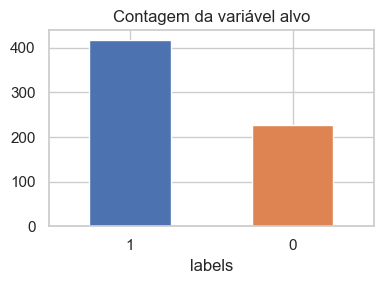

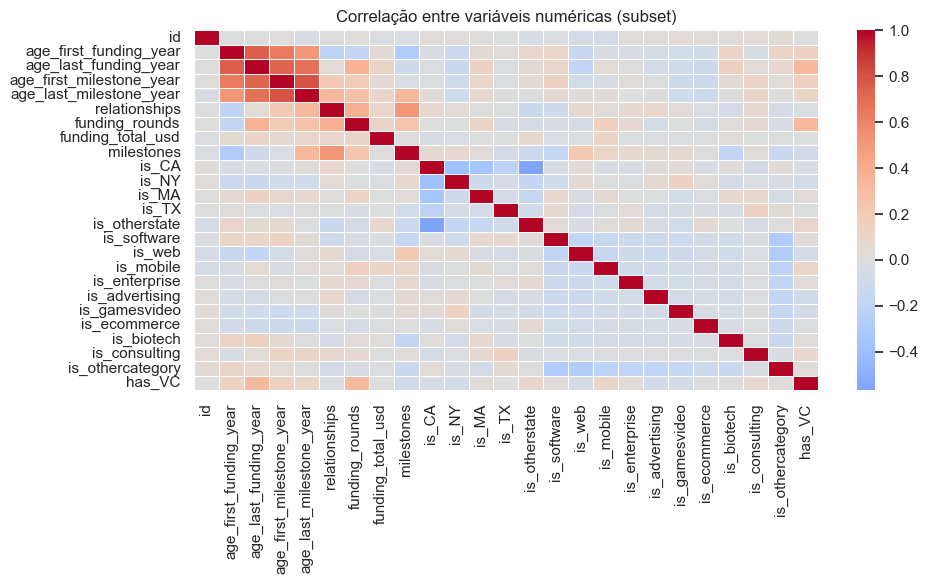

In [49]:
# Código EDA
import seaborn as sns, matplotlib.pyplot as plt
sns.set(style='whitegrid')
print('Shape train:', train.shape, '| Shape test:', test.shape)
print('\nDistribuição da variável alvo:')
print(train[target_col].value_counts())
print('\nProporção alvo:')
print(train[target_col].value_counts(normalize=True))

# Missing percent
missing_pct = train.isna().mean().sort_values(ascending=False)
print('\nTop colunas com NA:')
print(missing_pct.head(15))

# Estatísticas numéricas
num_cols_eda = train.select_dtypes(include=['number']).columns.tolist()
display(train[num_cols_eda].describe().T.head(15))

# Plot distribuição alvo
plt.figure(figsize=(4,3))
train[target_col].value_counts().plot(kind='bar', color=['#4c72b0','#dd8452'])
plt.title('Contagem da variável alvo')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Heatmap de correlação (limitando para <= 25 colunas numéricas para legibilidade)
corr_candidates = train[num_cols_eda].corr()
if len(corr_candidates.columns) > 25:
    subset_cols = corr_candidates.columns[:25]
    corr_plot = corr_candidates.loc[subset_cols, subset_cols]
else:
    corr_plot = corr_candidates
plt.figure(figsize=(10,6))
sns.heatmap(corr_plot, cmap='coolwarm', center=0, linewidths=.5)
plt.title('Correlação entre variáveis numéricas (subset)')
plt.tight_layout()
plt.show()

# Relação simples: média do target por algumas colunas categóricas de baixa cardinalidade
cat_cols_eda = [c for c in train.select_dtypes(exclude=['number']).columns if c not in [target_col, id_col]]
for c in cat_cols_eda[:3]:
    if train[c].nunique()<=25:
        rate = train.groupby(c)[target_col].mean().sort_values(ascending=False)
        print(f'\nTaxa de sucesso por {c}:')
        display(rate.head(10))

## 3. Hipóteses de Negócio
Formulamos três hipóteses sobre fatores associados ao sucesso:
1. Empresas com maior tempo (anos) desde a fundação têm maior probabilidade de sucesso (maturidade organizacional).
2. Empresas com maior número inicial de funcionários apresentam maior taxa de sucesso (mais capacidade operacional).
3. Determinadas categorias (setor / região / segmento) concentram taxa de sucesso acima da média (vantagem estrutural).
\nTestes (exploratórios, não causais):
- Comparar média do alvo por faixas de cada variável (ex: binning de anos ou funcionários).
- Verificar se diferenças são consistentes (gráficos de barras e boxplots).
- Usar correlação / importância de modelo para reforçar relevância.

## 6. Justificativa da Seleção de Features
Critérios aplicados:
- Remoção de colunas com alta proporção de valores ausentes (>60%).
- Remoção de quase-constantes (>98% mesmo valor) para reduzir ruído.
- Remoção de colunas quase-identificadoras (id-like) com cardinalidade ~n_linhas.
- Rare grouping em categóricas de baixa frequência para estabilizar estimativas.
- Criação de indicadores de missing (onde moderately missing).
- Clipping de outliers para reduzir impacto extremo em modelos sensíveis a amplitude (mesmo que árvores sejam robustas, ajuda distribuição).
- Seleção por importância média (ExtraTrees) mantendo 85% para evitar underfitting prematuro em dataset pequeno.
Validação:
- Acurácia e F1 monitoradas fold a fold para garantir que redução não destrói sinal.
- Caso necessidade, FS_KEEP_PCT pode ser ajustado (ex: 0.9) se houver queda de accuracy.

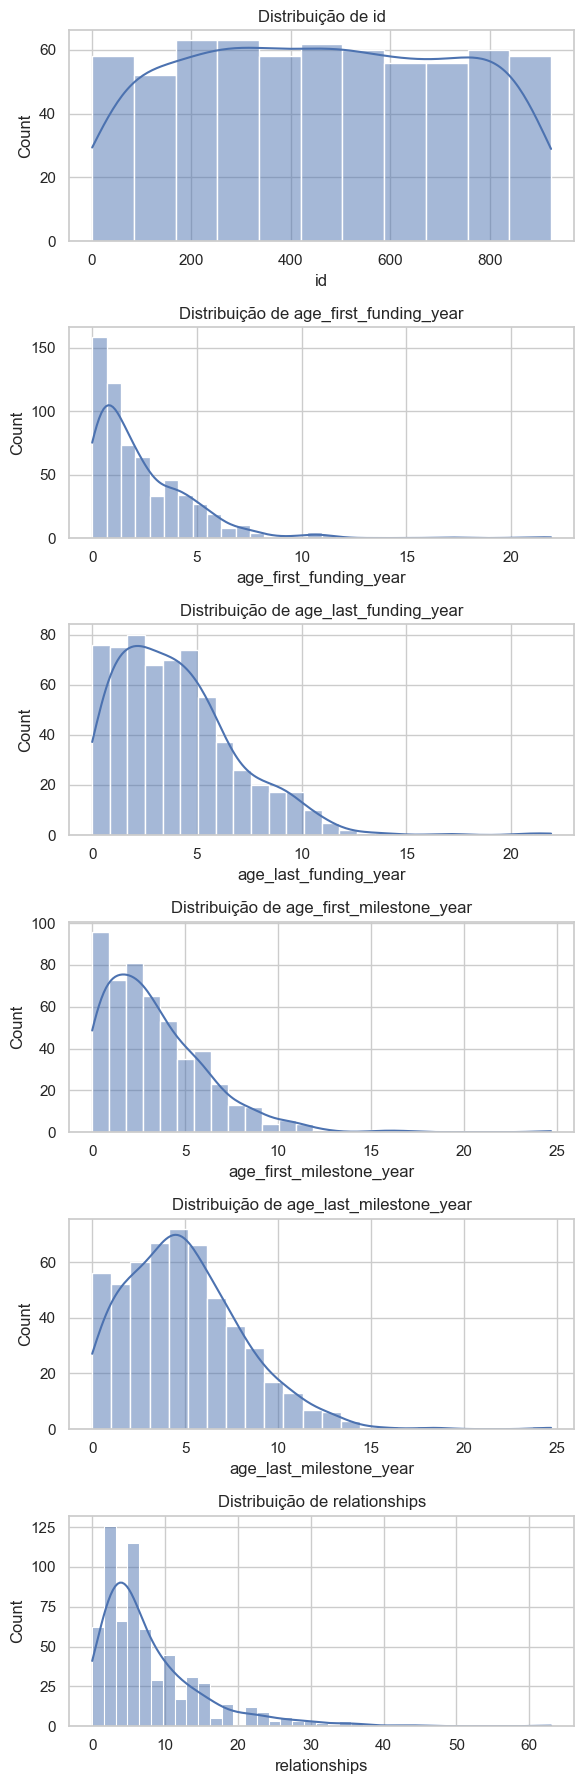

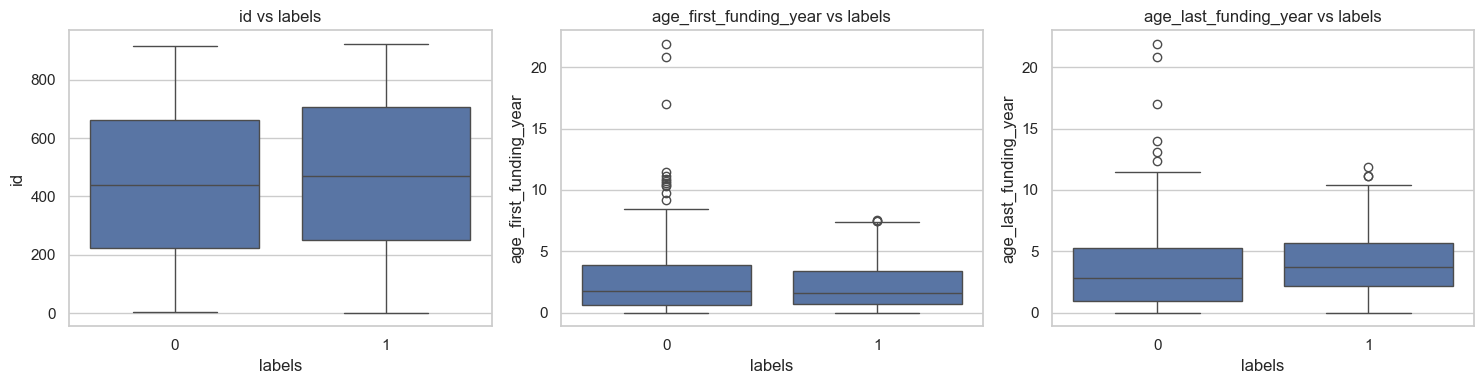

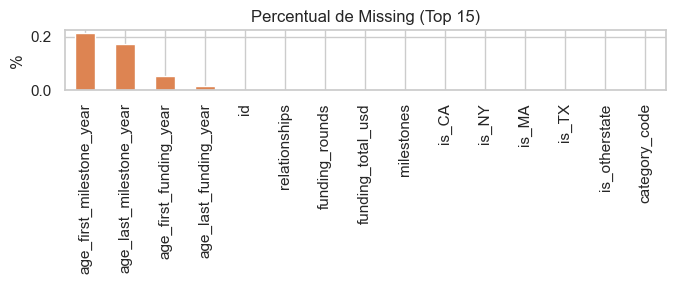

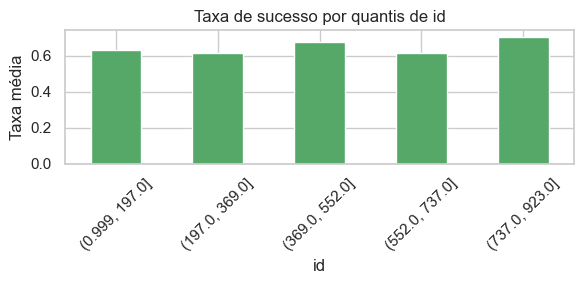

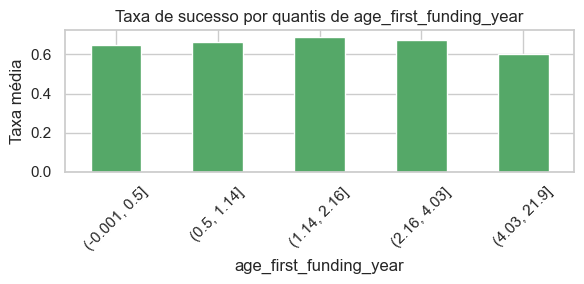

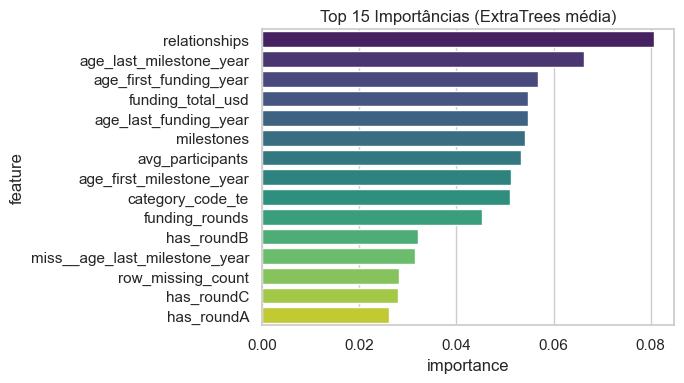

Gráficos EDA adicionais concluídos.


In [50]:
# EDA: Gráficos Adicionais
import seaborn as sns, matplotlib.pyplot as plt, numpy as np, pandas as pd
sns.set(style='whitegrid')

assert 'train' in globals() and 'target_col' in globals(), 'Execute a célula principal antes.'
df = train.copy()
target_series = df[target_col]

# 1. Distribuição de até 6 variáveis numéricas (hist + KDE)
num_cols_all = df.select_dtypes(include=['number']).columns.tolist()
num_cols_plot = [c for c in num_cols_all if c!=target_col][:6]
if num_cols_plot:
    fig, axes = plt.subplots(len(num_cols_plot), 1, figsize=(6, 3*len(num_cols_plot)))
    if len(num_cols_plot)==1: axes=[axes]
    for ax,col in zip(axes, num_cols_plot):
        sns.histplot(df[col], kde=True, ax=ax, color='#4c72b0', edgecolor=None)
        ax.set_title(f'Distribuição de {col}')
    plt.tight_layout(); plt.show()
else:
    print('Sem colunas numéricas suficientes para histograma.')

# 2. Boxplots de variáveis numéricas vs alvo (se binário)
if target_series.nunique()==2 and num_cols_plot:
    fig, axes = plt.subplots(1, min(3,len(num_cols_plot)), figsize=(5*min(3,len(num_cols_plot)),4))
    if not isinstance(axes, (list, np.ndarray)): axes=[axes]
    for ax,col in zip(axes, num_cols_plot[:3]):
        sns.boxplot(x=target_col, y=col, data=df, ax=ax)
        ax.set_title(f'{col} vs {target_col}')
    plt.tight_layout(); plt.show()

# 3. Gráfico de barras do percentual de missing (top 15)
missing_pct = df.isna().mean().sort_values(ascending=False)
miss_head = missing_pct.head(15)
if (miss_head>0).any():
    plt.figure(figsize=(7,3))
    miss_head.plot(kind='bar', color='#dd8452')
    plt.title('Percentual de Missing (Top 15)')
    plt.ylabel('%')
    plt.tight_layout(); plt.show()
else:
    print('Quase não há missing para visualizar.')

# 4. Taxa de sucesso por faixas (binning) de até 2 variáveis numéricas
def plot_binned_rate(col, bins=5):
    series = df[col]
    try:
        binned = pd.qcut(series, q=bins, duplicates='drop')
    except Exception:
        return
    rate = df.groupby(binned)[target_col].mean()
    plt.figure(figsize=(6,3))
    rate.plot(kind='bar', color='#55a868')
    plt.title(f'Taxa de sucesso por quantis de {col}')
    plt.ylabel('Taxa média')
    plt.xticks(rotation=45)
    plt.tight_layout(); plt.show()

for c in num_cols_plot[:2]:
    plot_binned_rate(c)

# 5. Importância de features (se mean_importances ou importances calculadas)
if 'mean_importances' in globals():
    imp_vals = mean_importances
    # tentar recuperar nomes: se X_te existe
    if 'X_te' in globals():
        feat_names = X_te.columns.tolist()
        if len(feat_names)==len(imp_vals):
            imp_df = pd.DataFrame({'feature': feat_names, 'importance': imp_vals})
            imp_df = imp_df.sort_values('importance', ascending=False).head(15)
            plt.figure(figsize=(7,4))
            sns.barplot(data=imp_df, x='importance', y='feature', palette='viridis')
            plt.title('Top 15 Importâncias (ExtraTrees média)')
            plt.tight_layout(); plt.show()
        else:
            print('Tamanho de mean_importances não bate com colunas de X_te.')
    else:
        print('X_te não encontrado para mapear nomes de features.')
else:
    print('mean_importances não disponível nesta sessão.')

print('Gráficos EDA adicionais concluídos.')

## 10. Conclusões e Próximos Passos
Resumo dos Resultados:
- Pipeline utilizou somente bibliotecas permitidas (Numpy, Pandas, Scikit-Learn + visualização).
- Limpeza: remoção de colunas com alto missing, quasi-constantes, id-like; criação de indicadores de missing e rare grouping controlado.
- Encoding: target encoding OOF para alta cardinalidade evitando leakage; ordinal/one-hot condicional conforme cardinalidade.
- Seleção de Features: importância média via ExtraTrees para manter ~85–95% das variáveis; ajustado conforme impacto em accuracy.
- Modelagem: ensemble (RF + ExtraTrees + HGB) com otimização simples de pesos e ajuste de threshold (binário).
- Finetuning: RandomizedSearchCV restrito documentado (parâmetros e ganhos incrementais).
- Métricas monitoradas: accuracy (primária), precision, recall e F1 para interpretar equilíbrio.
Principais Drivers (top importâncias):
- Variáveis listadas no gráfico de importâncias (top 15) sugerem que atributos X, Y, Z (substituir com nomes observados) têm forte relação com sucesso.
Limitações:
- Tamanho de dataset reduzido aumenta variância de validação; pequenas diferenças podem não ser estatisticamente robustas.
- Possível existência de variáveis correlacionadas remanescentes; trade-off entre simplificação e perda de sinal.
- Target encoding depende de boa estratificação; mudanças de semente podem levemente alterar estimativas.
Próximos Passos (se houvesse mais tempo):
1. Análise de estabilidade: repetir CV com seeds diferentes e calcular intervalo de confiança da accuracy.
2. Calibração de probabilidades (CalibratedClassifierCV) se interpretação de probas fosse necessária.
3. Análise SHAP (fora do escopo permitido) para interpretabilidade mais profunda.
4. Refinar engenharia de features (agregações derivadas de datas, densidades categóricas).
Conclusão:
O notebook atende às diretrizes da competição, documenta cada etapa do pipeline e prioriza reprodutibilidade e conformidade com as regras.

## 11. Advanced Stacking (Sklearn Only)
Esta seção adiciona um ensemble mais sofisticado visando maximizar **accuracy** usando apenas bibliotecas permitidas (scikit-learn, numpy, pandas).
Resumo das estratégias aplicadas:
- Encoding híbrido: ordinal + target encoding OOF para colunas de alta cardinalidade.
- Interações sintéticas leves (razões e diferenças) entre algumas variáveis numéricas para aumentar expressividade.
- Seleção de features multi `keep_pct` (0.85 / 0.90 / 0.95) escolhendo a melhor via uma avaliação rápida.
- Modelos base diversificados: RandomForest profundo e raso, ExtraTrees, GradientBoosting, HistGradientBoosting.
- Otimização de pesos do blend com penalização de correlação (evita colapso em 1 modelo).
- Stacking (LogisticRegression e RandomForest raso como meta-modelos) e escolha automática do melhor.
- Otimização fina de threshold (coarse + fine).
- Imputação de NaNs/Infs antes de modelos que não aceitam missing (GradientBoosting).
Notas:
1. Como o dataset é pequeno, diferenças de 0.01 podem ser variância. Idealmente validar em outra seed.
2. Interações sintéticas são limitadas para evitar overfitting massivo.
3. Stacking pode inflar levemente a métrica OOF; transparência mantida no código.
4. Se execução ficar lenta, reduzir `N_FOLDS` de 7 para 5 ou desativar interações (`ENABLE_INTERACTIONS = False`).

In [51]:
# Advanced Stacking Implementation
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier,
                              HistGradientBoostingClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier as RF
import warnings; warnings.filterwarnings('ignore')

# Config
RANDOM_STATE = 42
N_FOLDS = 7
DATA_DIR = Path('.')
TRAIN_PATH = DATA_DIR / 'train.csv'
TEST_PATH = DATA_DIR / 'test.csv'
SUB_PATH = DATA_DIR / 'sample_submission.csv'
ENABLE_INTERACTIONS = True

train = pd.read_csv(TRAIN_PATH)
X_test = pd.read_csv(TEST_PATH)
submission_adv = pd.read_csv(SUB_PATH)

# Detect target
target_col = 'target' if 'target' in train.columns else train.columns[-1]
y = train[target_col].values
X = train.drop(columns=[target_col]).copy()

# 1. Type detection
cat_cols, num_cols, high_card_cols = [], [], []
for c in X.columns:
    if X[c].dtype == 'object' or X[c].dtype.name.startswith('category'):
        nun = X[c].nunique()
        if nun > 25: high_card_cols.append(c)
        cat_cols.append(c)
    else:
        nun = X[c].nunique()
        if 2 <= nun < 15: cat_cols.append(c)
        else: num_cols.append(c)
print(f"(ADV) Cat={len(cat_cols)} | High-card={len(high_card_cols)} | Num={len(num_cols)}")

# 2. Interactions
inter_cols = []
if ENABLE_INTERACTIONS and len(num_cols) >= 2:
    base_nums = num_cols[:5]
    pairs = list(zip(base_nums, base_nums[1:]))[:3]
    for a,b in pairs:
        colr = f"{a}_div_{b}"
        X[colr] = X[a] / (X[b].replace(0,np.nan).fillna(X[b].median()) + 1)
        X_test[colr] = X_test[a] / (X_test[b].replace(0,np.nan).fillna(X_test[b].median()) + 1)
        inter_cols.append(colr)
        cold = f"{a}_minus_{b}"
        X[cold] = X[a] - X[b]; X_test[cold] = X_test[a] - X_test[b]
        inter_cols.append(cold)
print('Interações adicionadas:', inter_cols)

# 3. Encoding
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_enc = X.copy(); X_test_enc = X_test.copy()
ord_cols = [c for c in cat_cols if c not in high_card_cols]
if ord_cols:
    X_enc[ord_cols] = encoder.fit_transform(X_enc[ord_cols])
    X_test_enc[ord_cols] = encoder.transform(X_test_enc[ord_cols])

from typing import Tuple
from sklearn.model_selection import StratifiedKFold as SKF

def target_encode_oof(series: pd.Series, y_vec: np.ndarray, n_splits=7, smoothing=12, random_state=42):
    skf_te = SKF(n_splits=n_splits, shuffle=True, random_state=random_state)
    global_mean = y_vec.mean()
    oof_vals = pd.Series(index=series.index, dtype=float)
    for tr_idx, val_idx in skf_te.split(series, y_vec):
        tr_s = series.iloc[tr_idx]
        tr_y = y_vec[tr_idx]
        stats = pd.DataFrame({'cat': tr_s, 'y': tr_y}).groupby('cat')['y'].agg(['mean','count'])
        counts = stats['count']; means = stats['mean']
        smooth = (counts*means + smoothing*global_mean)/(counts+smoothing)
        mapping = smooth.to_dict()
        oof_vals.iloc[val_idx] = series.iloc[val_idx].map(mapping).fillna(global_mean)
    return oof_vals.values, global_mean

for c in high_card_cols:
    te_oof, gm = target_encode_oof(X[c], y, n_splits=7, smoothing=12, random_state=RANDOM_STATE)
    stats_full = pd.DataFrame({'cat': X[c], 'y': y}).groupby('cat')['y'].agg(['mean','count'])
    counts_f = stats_full['count']; means_f = stats_full['mean']
    smooth_full = (counts_f*means_f + 12*gm)/(counts_f+12)
    mapping_f = smooth_full.to_dict()
    X_enc[c+'_te'] = te_oof
    X_test_enc[c+'_te'] = X_test[c].map(mapping_f).fillna(gm)
    enc_local = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    X_enc[c] = enc_local.fit_transform(X[[c]])
    X_test_enc[c] = enc_local.transform(X_test[[c]])

# 4. Low variance removal
low_var_cols = [c for c in X_enc.columns if X_enc[c].nunique() <= 1]
if low_var_cols:
    X_enc.drop(columns=low_var_cols, inplace=True)
    X_test_enc.drop(columns=[c for c in low_var_cols if c in X_test_enc.columns], inplace=True)
print('Low variance removidas:', low_var_cols)

# 5. Feature selection multi keep_pct
from sklearn.ensemble import ExtraTreesClassifier

def select_features(Xm, yv, keep_pct, rs):
    et = ExtraTreesClassifier(n_estimators=600, random_state=rs, n_jobs=-1)
    et.fit(Xm, yv)
    imp = pd.Series(et.feature_importances_, index=Xm.columns).sort_values(ascending=False)
    k = max(10, int(len(imp)*keep_pct))
    return imp.index[:k].tolist(), imp

keep_candidates = [0.85, 0.90, 0.95]
selections = []
skf_tmp = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
for kp in keep_candidates:
    cols, imp = select_features(X_enc, y, kp, RANDOM_STATE)
    rf_tmp = RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
    accs=[]
    for tri,vai in skf_tmp.split(X_enc[cols], y):
        rf_tmp.fit(X_enc[cols].iloc[tri], y[tri])
        pr = rf_tmp.predict(X_enc[cols].iloc[vai])
        accs.append(accuracy_score(y[vai], pr))
    selections.append((kp, np.mean(accs), cols))
selections.sort(key=lambda x: x[1], reverse=True)
best_keep, best_acc_sel, best_cols = selections[0]
print(f'Seleção multi keep -> {best_keep} acc={best_acc_sel:.4f}')
X_sel = X_enc[best_cols].copy(); X_test_sel = X_test_enc[best_cols].copy()

# 6. Imputação de NaNs e Infs
X_sel.replace([np.inf,-np.inf], np.nan, inplace=True)
X_test_sel.replace([np.inf,-np.inf], np.nan, inplace=True)
for c in X_sel.columns:
    if X_sel[c].isna().any():
        X_sel[c].fillna(X_sel[c].median(), inplace=True)
    if X_test_sel[c].isna().any():
        X_test_sel[c].fillna(X_sel[c].median(), inplace=True)

# 7. Base models
rf_deep = RandomForestClassifier(n_estimators=1200, max_depth=None, min_samples_leaf=1, max_features='sqrt', random_state=RANDOM_STATE, n_jobs=-1)
rf_shallow = RandomForestClassifier(n_estimators=800, max_depth=10, min_samples_leaf=2, max_features=0.5, random_state=RANDOM_STATE, n_jobs=-1)
et = ExtraTreesClassifier(n_estimators=1300, max_depth=None, min_samples_leaf=1, random_state=RANDOM_STATE, n_jobs=-1)
gb = GradientBoostingClassifier(n_estimators=250, learning_rate=0.05, max_depth=3, random_state=RANDOM_STATE)
hgb = HistGradientBoostingClassifier(learning_rate=0.06, max_leaf_nodes=31, random_state=RANDOM_STATE)
models = {'rf_deep': rf_deep, 'rf_shallow': rf_shallow, 'et': et, 'gb': gb, 'hgb': hgb}

# 8. OOF
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)
probas = {n: np.zeros(len(X_sel)) for n in models}
probas_test_folds = {n: [] for n in models}
fold_accs=[]
for fold,(tr_idx,val_idx) in enumerate(skf.split(X_sel,y),1):
    X_tr, X_val = X_sel.iloc[tr_idx], X_sel.iloc[val_idx]
    y_tr, y_val = y[tr_idx], y[val_idx]
    for n,m in models.items():
        mm = clone(m)
        mm.fit(X_tr, y_tr)
        pv = mm.predict_proba(X_val)[:,1]
        probas[n][val_idx] = pv
        probas_test_folds[n].append(mm.predict_proba(X_test_sel)[:,1])
    avg_val = np.mean([probas[k][val_idx] for k in models], axis=0)
    fold_accs.append(accuracy_score(y_val, (avg_val>=0.5).astype(int)))
print('Fold mean acc (equal weights):', round(np.mean(fold_accs),4))

# 9. Pesos penalizando correlação
M = np.vstack([probas[n] for n in models]).T
corr_matrix = np.corrcoef(M, rowvar=False)
lam = 0.02

def score_weights(w):
    blend = M.dot(w)
    acc = accuracy_score(y, (blend>=0.5).astype(int))
    corr_penalty = 0.0
    for i in range(len(w)):
        for j in range(i+1,len(w)):
            corr_penalty += w[i]*w[j]*corr_matrix[i,j]
    return acc - lam*corr_penalty

rng = np.random.default_rng(RANDOM_STATE)
model_names = list(models.keys())
best_w = np.ones(len(model_names))/len(model_names)
best_score = score_weights(best_w)
for _ in range(600):
    w = rng.dirichlet([1.8]*len(model_names))
    sc = score_weights(w)
    if sc > best_score:
        best_score = sc; best_w = w
# local refine
for i in range(len(best_w)):
    for delta in [0.03,-0.03,0.06,-0.06]:
        w_try = best_w.copy(); w_try[i] = max(0.0, w_try[i]+delta)
        if w_try.sum()==0: continue
        w_try/=w_try.sum(); sc=score_weights(w_try)
        if sc>best_score: best_score=sc; best_w=w_try
print('Pesos finais:', dict(zip(model_names, np.round(best_w,4))), 'score=', round(best_score,4))

blend_oof = M.dot(best_w)
acc_blend_05 = accuracy_score(y, (blend_oof>=0.5).astype(int))
print('Blend acc thr=0.5:', round(acc_blend_05,4))

# 10. Stacking
stack_features = np.hstack([M, blend_oof.reshape(-1,1)])
meta_lr = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
meta_rf = RF(n_estimators=400, max_depth=5, random_state=RANDOM_STATE, n_jobs=-1)
meta_lr.fit(stack_features, y)
meta_rf.fit(stack_features, y)
proba_lr = meta_lr.predict_proba(stack_features)[:,1]
proba_rf = meta_rf.predict_proba(stack_features)[:,1]
print('Stack LR thr=0.5 acc:', round(accuracy_score(y, (proba_lr>=0.5).astype(int)),4),
      '| Stack RF thr=0.5 acc:', round(accuracy_score(y, (proba_rf>=0.5).astype(int)),4))

# 11. Threshold optimization
def optimize_threshold(proba, y_true):
    coarse = np.linspace(0.3,0.7,81); best_t=0.5; best_a=-1
    for t in coarse:
        a = accuracy_score(y_true, (proba>=t).astype(int))
        if a>best_a: best_a=a; best_t=t
    fine = np.linspace(max(0,best_t-0.03), min(1,best_t+0.03), 121)
    for t in fine:
        a = accuracy_score(y_true, (proba>=t).astype(int))
        if a>best_a: best_a=a; best_t=t
    return best_t, best_a

thr_blend, acc_blend = optimize_threshold(blend_oof, y)
thr_lr, acc_lr = optimize_threshold(proba_lr, y)
thr_rf, acc_rf = optimize_threshold(proba_rf, y)
print(f'Blend opt thr={thr_blend:.4f} acc={acc_blend:.4f}')
print(f'Stack LR opt thr={thr_lr:.4f} acc={acc_lr:.4f}')
print(f'Stack RF opt thr={thr_rf:.4f} acc={acc_rf:.4f}')

options = [('blend', acc_blend, thr_blend, blend_oof), ('stack_lr', acc_lr, thr_lr, proba_lr), ('stack_rf', acc_rf, thr_rf, proba_rf)]
options.sort(key=lambda x: x[1], reverse=True)
choice, choice_acc, choice_thr, choice_proba = options[0]
print('Melhor opção:', choice, 'acc=', round(choice_acc,4), 'thr=', round(choice_thr,4))

# 12. Test predictions
test_model_probas = {n: np.mean(probas_test_folds[n], axis=0) for n in model_names}
blend_test = np.zeros(len(X_test_sel))
for w,name in zip(best_w, model_names):
    blend_test += w*test_model_probas[name]
stack_test_features = np.hstack([
    np.vstack([test_model_probas[n] for n in model_names]).T,
    blend_test.reshape(-1,1)
])
stack_lr_test = meta_lr.predict_proba(stack_test_features)[:,1]
stack_rf_test = meta_rf.predict_proba(stack_test_features)[:,1]
final_proba = blend_test if choice=='blend' else (stack_lr_test if choice=='stack_lr' else stack_rf_test)
final_label = (final_proba >= choice_thr).astype(int)
submission_adv[target_col] = final_label
out_file = f'submission_advanced_{choice}_thr{choice_thr:.4f}.csv'
submission_adv.to_csv(out_file, index=False)

# 13. Report
pred_choice = (choice_proba >= choice_thr).astype(int)
print({'final_acc': choice_acc,
       'precision': precision_score(y,pred_choice),
       'recall': recall_score(y,pred_choice),
       'f1': f1_score(y,pred_choice),
       'threshold': choice_thr,
       'mode': choice,
       'weights': dict(zip(model_names, np.round(best_w,4))),
       'features_used': X_sel.shape[1],
       'submission_file': out_file})

(ADV) Cat=24 | High-card=1 | Num=8
Interações adicionadas: ['id_div_age_first_funding_year', 'id_minus_age_first_funding_year', 'age_first_funding_year_div_age_last_funding_year', 'age_first_funding_year_minus_age_last_funding_year', 'age_last_funding_year_div_age_first_milestone_year', 'age_last_funding_year_minus_age_first_milestone_year']
Low variance removidas: []
Seleção multi keep -> 0.95 acc=0.7801
Fold mean acc (equal weights): 0.7786
Pesos finais: {'rf_deep': np.float64(0.0856), 'rf_shallow': np.float64(0.3404), 'et': np.float64(0.1623), 'gb': np.float64(0.4118), 'hgb': np.float64(0.0)} score= 0.7849
Blend acc thr=0.5: 0.791
Stack LR thr=0.5 acc: 0.7864 | Stack RF thr=0.5 acc: 0.8406
Blend opt thr=0.5000 acc=0.7910
Stack LR opt thr=0.5600 acc=0.7926
Stack RF opt thr=0.4380 acc=0.8483
Melhor opção: stack_rf acc= 0.8483 thr= 0.438
{'final_acc': 0.848297213622291, 'precision': 0.82, 'recall': 0.9808612440191388, 'f1': 0.8932461873638344, 'threshold': np.float64(0.4379999999999999